<a href="https://colab.research.google.com/github/cmreyesvalencia-png/colab-git-assignment2-CR/blob/main/Lesson_10_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 10: Customer Review Sentiment Analysis**
- **Course:** Data Analytics and Business Intelligence Analyst
- **Institution:** Willis College
- **Student Name:**  Carlos Reyes
- **Instructor:** Ratinder Rajpal
- **Date:** 2025 Nov, 09


# **Dataset:Twitter US Airline- February 2015**

# **Step1: Data Selection and Preprocessing:**

In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset from GitHub

url = "https://raw.githubusercontent.com/cmreyesvalencia-png/colab-git-assignment2-CR/main/Tweets.csv"

try:
    data_df = pd.read_csv(url)
    print("Data loaded successfully!")
    print("\nFirst 5 rows:")
    print(data_df.head())
    print("\nDataset info:")
    print(data_df.info())
    print("\nDataset shape:", data_df.shape)
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully!

First 5 rows:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN          

In [ ]:
# Dataset Selection and Preprocessing
print("\n" + "="*50)
print("DATASET EXPLORATION AND PREPROCESSING")
print("="*50)

# Check for missing values
print("\nMissing values:")
print(data_df.isnull().sum())

# Check the distribution of sentiment labels
print("\nSentiment distribution:")
print(data_df['airline_sentiment'].value_counts())



DATASET EXPLORATION AND PREPROCESSING

Missing values:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


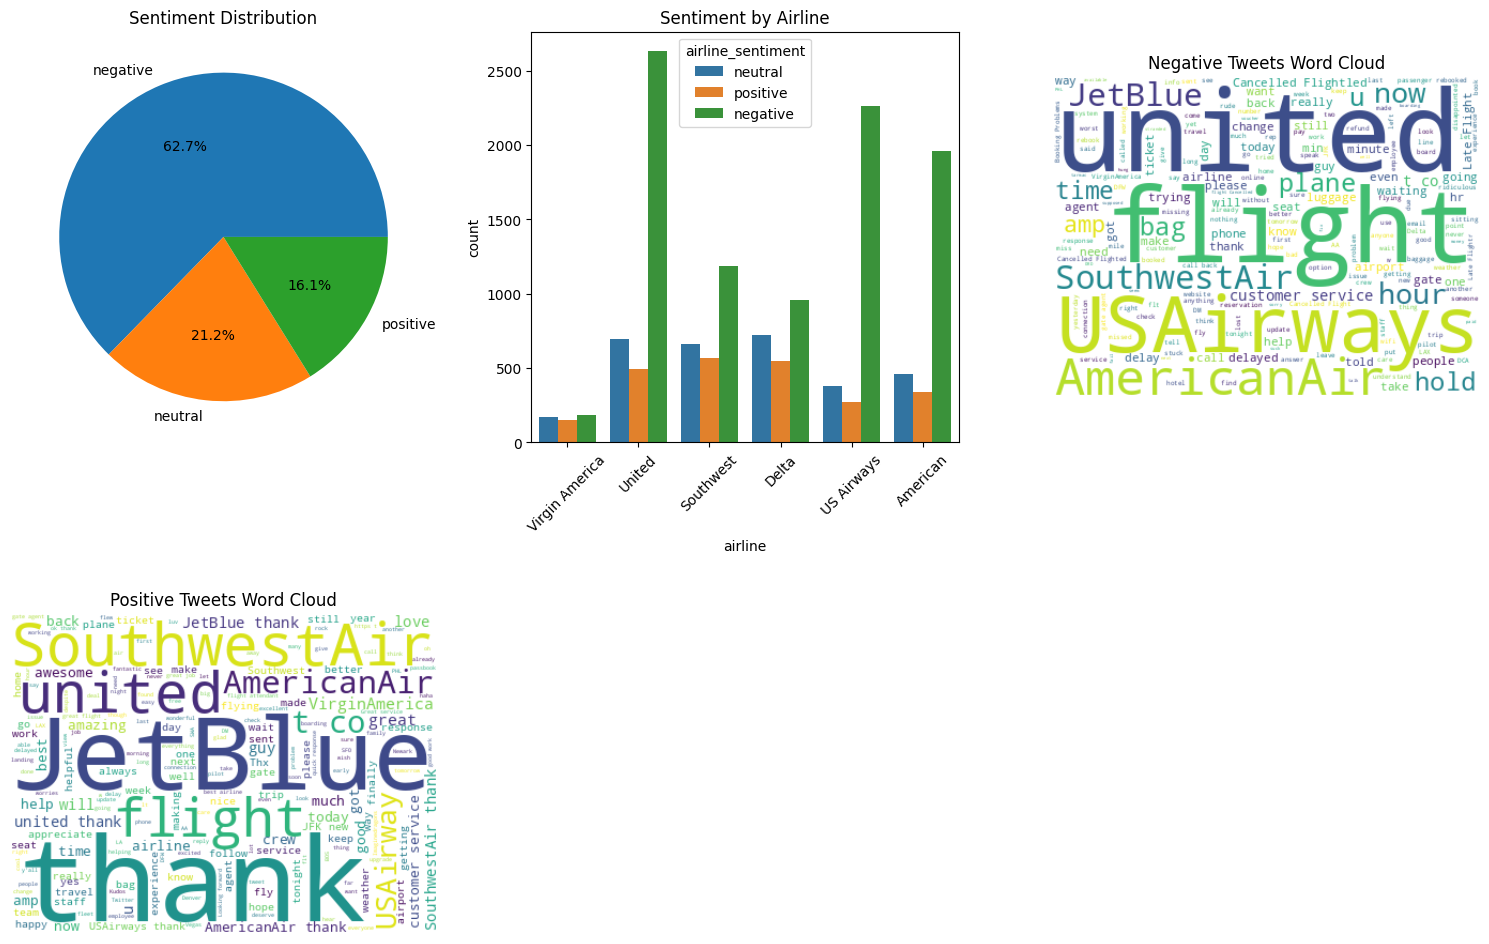

In [ ]:
# Data Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Sentiment distribution
plt.subplot(2, 3, 1)
sentiment_counts = data_df['airline_sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

# Plot 2: Sentiment by airline
plt.subplot(2, 3, 2)
sns.countplot(data=data_df, x='airline', hue='airline_sentiment')
plt.title('Sentiment by Airline')
plt.xticks(rotation=45)

# Plot 3: Most frequent words in negative tweets
plt.subplot(2, 3, 3)
negative_tweets = ' '.join(data_df[data_df['airline_sentiment'] == 'negative']['text'])
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(negative_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis('off')

# Plot 4: Most frequent words in positive tweets
plt.subplot(2, 3, 4)
positive_tweets = ' '.join(data_df[data_df['airline_sentiment'] == 'positive']['text'])
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(positive_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Text preprocessing function

def preprocess_text(text):
    # Remove mentions, URLs, and special characters
    text = re.sub(r'@\w+|https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply text preprocessing
print("\nPreprocessing text data...")
data_df['cleaned_text'] = data_df['text'].apply(preprocess_text)

# Encode the target variable
label_encoder = LabelEncoder()
data_df['sentiment_encoded'] = label_encoder.fit_transform(data_df['airline_sentiment'])

print("\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")



Preprocessing text data...

Label mapping:
negative: 0
neutral: 1
positive: 2


# **Step2: Feature Engineering:**

In [ ]:
# Feature Engineering
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# 1. Bag of Words
print("Creating Bag of Words features...")
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_bow = count_vectorizer.fit_transform(data_df['cleaned_text'])

# 2. TF-IDF
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(data_df['cleaned_text'])

# Prepare target variable
y = data_df['sentiment_encoded']


FEATURE ENGINEERING
Creating Bag of Words features...
Creating TF-IDF features...


Creating t-SNE visualization with sampling...
Using 2000 samples for t-SNE visualization
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.012s...
[t-SNE] Computed neighbors for 2000 samples in 2.811s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.497679
[t-SNE] KL divergence after 250 iterations with early exaggeration: 152.041992
[t-SNE] KL divergence after 500 iterations: 3.424156


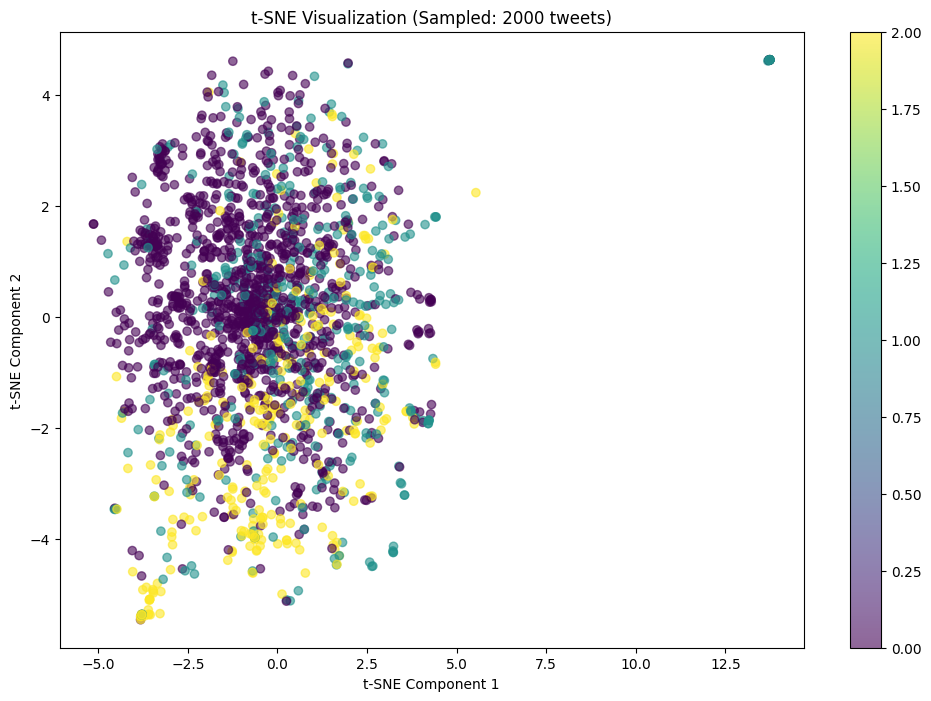

In [ ]:
# Visualize using data sampling

# Simple and robust sampling version
print("Creating t-SNE visualization with sampling...")

# Convert to dense array for easier handling (be careful with memory)
X_dense = X_tfidf.toarray()
sample_size = min(2000, X_dense.shape[0])

if X_dense.shape[0] > sample_size:
    # Use train_test_split for stratified sampling
    X_sampled, _, y_sampled, _ = train_test_split(
        X_dense, y, train_size=sample_size, stratify=y, random_state=42
    )
else:
    X_sampled, y_sampled = X_dense, y

print(f"Using {X_sampled.shape[0]} samples for t-SNE visualization")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500, verbose=1)
X_tsne = tsne.fit_transform(X_sampled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sampled, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f't-SNE Visualization (Sampled: {len(y_sampled)} tweets)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# **Step3: Text Classification Using Traditional Models:**

In [ ]:
# Text Classification Using Traditional Models
print("\n" + "="*50)
print("TEXT CLASSIFICATION USING TRADITIONAL MODELS")
print("="*50)

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC  # Add this import
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Split the data
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Define models and parameters for grid search
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, n_jobs=-1),
        'params': {
            'C': [0.1, 1, 10],
            'max_iter': [1000]
        }
    },
    'SVM': {
        'model': LinearSVC(random_state=42),  # Using LinearSVC instead of SVC for speed
        'params': {
            'C': [0.1, 1, 10],
            'max_iter': [1000]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100],  # Reduced from [100, 200]
            'max_depth': [10, 15],      # Reduced from [10, 20, None]
            'max_features': ['sqrt']    # Added to limit features per tree
        }
    }
}

# Train and evaluate models
results = {}

for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")

    # Use TF-IDF features for better performance
    X_train, X_test = X_train_tfidf, X_test_tfidf

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=3,  # Reduced from 5 to 3 for faster training
        scoring='accuracy',
        n_jobs=-1,
        verbose=1  # Add progress output
    )

    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Store results
    results[model_name] = {
        'model': best_model,
        'predictions': y_pred,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred)
    }

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


TEXT CLASSIFICATION USING TRADITIONAL MODELS

Training Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'C': 1, 'max_iter': 1000}
Accuracy: 0.7862

Training SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'C': 1, 'max_iter': 1000}
Accuracy: 0.7824

Training Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy: 0.6366



MODEL EVALUATION


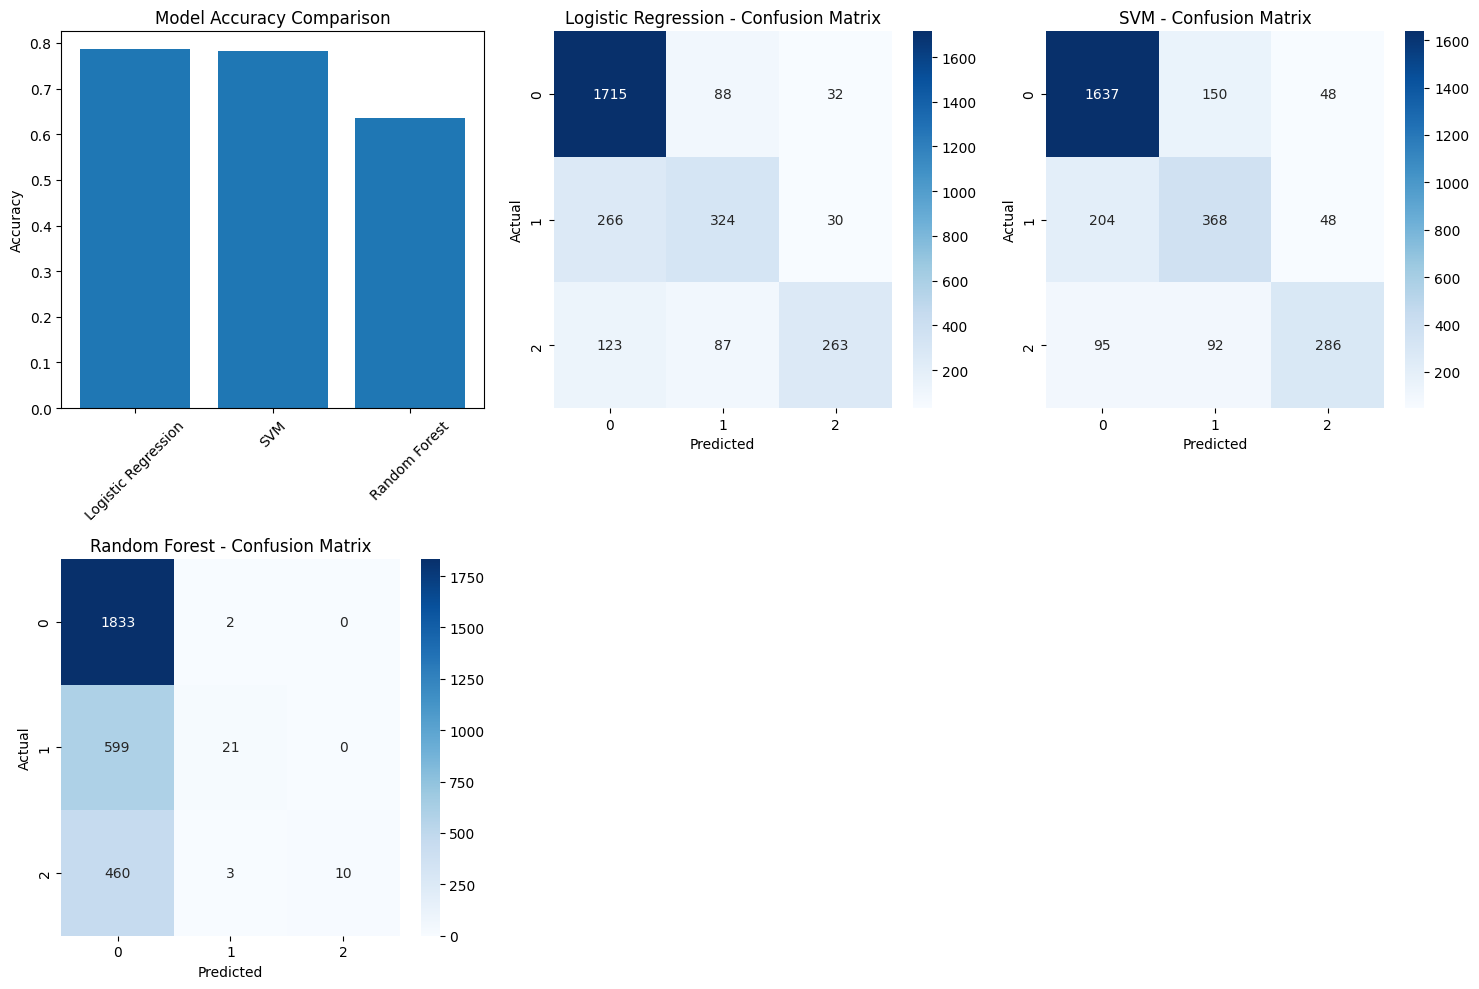

In [ ]:
# Model Evaluation
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Compare model performance
plt.figure(figsize=(15, 10))

# Plot 1: Accuracy comparison
plt.subplot(2, 3, 1)
accuracies = [results[model]['accuracy'] for model in results.keys()]
plt.bar(results.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

# Plot confusion matrices and ROC curves for each model
for i, (model_name, result) in enumerate(results.items()):
    # Confusion Matrix
    plt.subplot(2, 3, i+2)
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1835
     neutral       0.65      0.52      0.58       620
    positive       0.81      0.56      0.66       473

    accuracy                           0.79      2928
   macro avg       0.76      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928


              precision    recall  f1-score   support

    negative       0.85      0.89      0.87      1835
     neutral       0.60      0.59      0.60       620
    positive       0.75      0.60      0.67       473

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928


              precision    recall  f1-score   support

    negative       0.63      1.00      0.78      1835
     neutral       0.81      0.03      0.07       620
    positive       1.00      0.02      0.04       473

    accuracy     

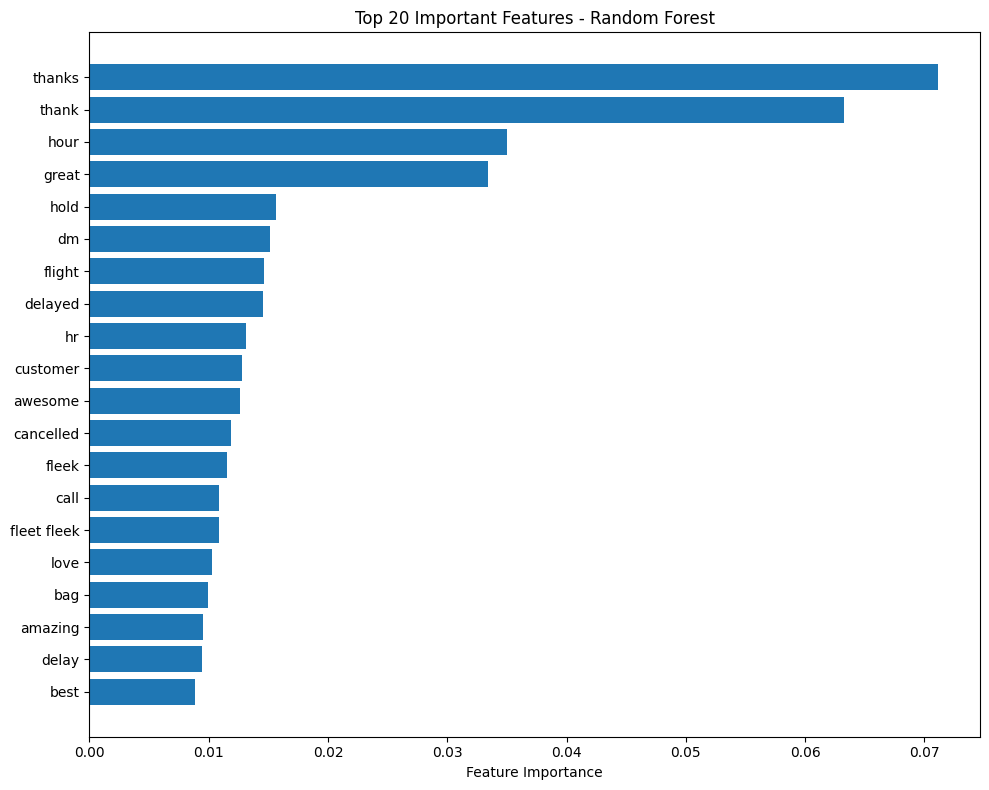

In [ ]:
# Print detailed classification reports
for model_name, result in results.items():
    print(f"\n{classification_report(y_test, result['predictions'], target_names=label_encoder.classes_)}")

# Feature Importance for Random Forest
print("\n" + "="*50)
print("FEATURE IMPORTANCE - RANDOM FOREST")
print("="*50)

rf_model = results['Random Forest']['model']
feature_names = count_vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_

# Get top 20 important features
indices = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 20 Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# **Step4: Sentiment Analysis Using a Large Language Model:**

In [ ]:
# Sentiment Analysis Using Large Language Model (BERT) - OPTIMIZED
print("\n" + "="*50)
print("SENTIMENT ANALYSIS USING BERT - FAST VERSION")
print("="*50)

try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
    import torch
    from torch.utils.data import Dataset
    import numpy as np
    from sklearn.metrics import classification_report, accuracy_score
    import time

    start_time = time.time()

    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load pre-trained BERT model and tokenizer
    model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(device)

    # Create a custom dataset
    class TweetDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=64):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = str(self.texts[idx])
            label = self.labels[idx]

            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # Prepare data for BERT - USE SMALLER SUBSET FOR SPEED
    print("Preparing optimized dataset for BERT training...")

    # Use smaller subset for faster training
    if len(data_df) > 800:
        train_df = data_df.sample(n=800, random_state=42)
        print(f"Using 800 samples (subset) for faster training")
    else:
        train_df = data_df

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].tolist(),
        train_df['sentiment_encoded'].tolist(),
        test_size=0.15,
        random_state=42,
        stratify=train_df['sentiment_encoded']
    )

    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")

    train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
    val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

    # OPTIMIZED Training arguments for SPEED
    training_args = TrainingArguments(
        output_dir='./bert_results',
        num_train_epochs=1,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        warmup_steps=30,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,
        eval_strategy="no",
        save_strategy="no",
        load_best_model_at_end=False,
        report_to=[],
        dataloader_pin_memory=False,
        remove_unused_columns=False,
    )

    print("Using optimized training parameters for speed")
    print("Training configuration: 1 epoch, batch size 8, no validation during training")

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )

    # Fine-tune the model
    print("\n" + "="*50)
    print("STARTING BERT FINE-TUNING")
    print("="*50)
    training_start = time.time()

    trainer.train()

    training_time = time.time() - training_start
    print(f"✓ Fine-tuning completed in {training_time:.2f} seconds")

    # Evaluate the model
    print("\n" + "="*50)
    print("EVALUATING BERT MODEL")
    print("="*50)

    bert_predictions = trainer.predict(val_dataset)
    bert_preds = np.argmax(bert_predictions.predictions, axis=1)

    # Calculate metrics
    bert_accuracy = accuracy_score(val_labels, bert_preds)

    print(f"✓ BERT Fine-tuned Accuracy: {bert_accuracy:.4f}")
    print(f"✓ Validation samples: {len(val_labels)}")

    print("\nBERT Classification Report:")
    print(classification_report(val_labels, bert_preds, target_names=label_encoder.classes_))

    # Compare with traditional models
    if 'results' in locals():
        print("\n" + "="*50)
        print("FINAL MODEL COMPARISON")
        print("="*50)
        comparison_data = []
        for model_name, result in results.items():
            comparison_data.append({
                'Model': model_name,
                'Accuracy': result['accuracy'],
                'Type': 'Traditional ML'
            })

        comparison_data.append({
            'Model': 'BERT (Fine-tuned)',
            'Accuracy': bert_accuracy,
            'Type': 'Transformer'
        })

        comparison_df = pd.DataFrame(comparison_data)
        print("\nModel Performance Ranking:")
        print(comparison_df.sort_values('Accuracy', ascending=False).to_string(index=False))

        best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
        print(f"\n🏆 Best Performing Model: {best_model['Model']} (Accuracy: {best_model['Accuracy']:.4f})")

    total_time = time.time() - start_time
    print(f"\n✅ Complete BERT analysis finished in {total_time:.2f} seconds")

except ImportError:
    print("Transformers library not available. Install with: pip install transformers")
except Exception as e:
    print(f"Error with BERT implementation: {e}")

# Alternative: Ultra-fast BERT without fine-tuning
print("\n" + "="*50)
print("ALTERNATIVE: ULTRA-FAST BERT (No Fine-tuning)")
print("="*50)

try:
    from transformers import pipeline

    print("Loading BERT for instant inference (no training)...")
    classifier = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest"
    )

    # Quick evaluation on sample data
    sample_data = data_df.sample(n=100, random_state=42)
    sample_texts = sample_data['text'].tolist()
    sample_true = sample_data['airline_sentiment'].tolist()

    print("Making fast predictions...")
    predictions = []
    for text in sample_texts:
        result = classifier(str(text))[0]
        predictions.append(result['label'])

    # Map predictions
    def map_prediction(pred):
        pred = pred.lower()
        if 'negative' in pred: return 'negative'
        elif 'positive' in pred: return 'positive'
        else: return 'neutral'

    bert_preds_fast = [map_prediction(pred) for pred in predictions]
    accuracy_fast = np.mean([true == pred for true, pred in zip(sample_true, bert_preds_fast)])

    print(f"✓ BERT (No fine-tuning) Accuracy: {accuracy_fast:.4f}")
    print(f"✓ Sample size: {len(sample_texts)}")
    print(f"✓ Instant results - no training needed!")

except Exception as e:
    print(f"Error with fast BERT: {e}")


SENTIMENT ANALYSIS USING BERT - FAST VERSION
Using device: cpu
Loading model and tokenizer...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing optimized dataset for BERT training...
Using 800 samples (subset) for faster training
Training samples: 680, Validation samples: 120
Using optimized training parameters for speed
Training configuration: 1 epoch, batch size 8, no validation during training

STARTING BERT FINE-TUNING


Step,Training Loss
50,0.569500


✓ Fine-tuning completed in 542.40 seconds

EVALUATING BERT MODEL


✓ BERT Fine-tuned Accuracy: 0.9000
✓ Validation samples: 120

BERT Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.96      0.94        75
     neutral       0.86      0.73      0.79        26
    positive       0.89      0.89      0.89        19

    accuracy                           0.90       120
   macro avg       0.89      0.86      0.87       120
weighted avg       0.90      0.90      0.90       120


FINAL MODEL COMPARISON

Model Performance Ranking:
              Model  Accuracy           Type
  BERT (Fine-tuned)  0.900000    Transformer
Logistic Regression  0.786202 Traditional ML
                SVM  0.782445 Traditional ML
      Random Forest  0.636612 Traditional ML

🏆 Best Performing Model: BERT (Fine-tuned) (Accuracy: 0.9000)

✅ Complete BERT analysis finished in 572.56 seconds

ALTERNATIVE: ULTRA-FAST BERT (No Fine-tuning)
Loading BERT for instant inference (no training)...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Making fast predictions...
✓ BERT (No fine-tuning) Accuracy: 0.8500
✓ Sample size: 100
✓ Instant results - no training needed!


# **Step5: Model Evaluation:**

In [ ]:
# Final Model Comparison
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()]
})

if 'bert_accuracy' in locals():
    # BERT from fine-tuning
    comparison_df = pd.concat([
        comparison_df,
        pd.DataFrame({'Model': ['BERT (Fine-tuned)'], 'Accuracy': [bert_accuracy]})
    ], ignore_index=True)

elif 'accuracy_fast' in locals():
    # BERT from no fine-tuning
    comparison_df = pd.concat([
        comparison_df,
        pd.DataFrame({'Model': ['BERT (No Fine-tuning)'], 'Accuracy': [accuracy_fast]})
    ], ignore_index=True)
    print("✓ Added BERT (no fine-tuning) to comparison")

else:
    # Calculate BERT accuracy if predictions exist
    try:
        if 'bert_preds' in locals() and 'val_labels' in locals():
            bert_accuracy = accuracy_score(val_labels, bert_preds)
            comparison_df = pd.concat([
                comparison_df,
                pd.DataFrame({'Model': ['BERT'], 'Accuracy': [bert_accuracy]})
            ], ignore_index=True)
            print("✓ Calculated and added BERT accuracy")
        else:
            print("⚠ BERT results not available for comparison")
    except:
        print("⚠ Could not calculate BERT accuracy")

print("\n" + comparison_df.to_string(index=False))

# Enhanced prediction function that includes BERT
def predict_sentiment(text, model_type='bert'):  # Changed default to BERT
    """
    Predict sentiment of new text using trained models including BERT
    """
    if model_type == 'bert':
        # Use BERT for prediction
        try:
            from transformers import pipeline
            classifier = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest"
            )
            result = classifier(text)[0]

            # Map BERT output to our labels
            bert_label = result['label'].lower()
            if 'negative' in bert_label:
                sentiment = 'negative'
            elif 'positive' in bert_label:
                sentiment = 'positive'
            else:
                sentiment = 'neutral'

            return sentiment
        except Exception as e:
            return f'Error: {e}'

    else:
        # Traditional models
        cleaned_text = preprocess_text(text)

        if model_type == 'random_forest':
            vectorized_text = count_vectorizer.transform([cleaned_text])
            model = results['Random Forest']['model']
        elif model_type == 'logistic_regression':
            vectorized_text = tfidf_vectorizer.transform([cleaned_text])
            model = results['Logistic Regression']['model']
        elif model_type == 'svm':
            vectorized_text = tfidf_vectorizer.transform([cleaned_text])
            model = results['SVM']['model']
        else:
            raise ValueError("Invalid model type")

        prediction = model.predict(vectorized_text)[0]
        sentiment = label_encoder.inverse_transform([prediction])[0]

        return sentiment

# Example usage with ALL models
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS - ALL MODELS")
print("="*50)

test_reviews = [
    "I love flying with this airline! Great service and comfortable seats.",
    "The worst flight experience ever. Delayed for 5 hours with no explanation.",
    "Average service, nothing special but acceptable."
]

for review in test_reviews:
    print(f"Review: {review}")

    # Try all available models
    models_to_try = []

    # Add traditional models
    if 'Random Forest' in results:
        models_to_try.append('random_forest')
    if 'Logistic Regression' in results:
        models_to_try.append('logistic_regression')
    if 'SVM' in results:
        models_to_try.append('svm')

    # Always try BERT
    models_to_try.append('bert')

    for model_type in models_to_try:
        try:
            prediction = predict_sentiment(review, model_type)
            print(f"  {model_type.replace('_', ' ').title()}: {prediction}")
        except Exception as e:
            print(f"  {model_type.replace('_', ' ').title()}: Error - {e}")

    print()  # Empty line between reviews

print("Sentiment analysis completed successfully!")


FINAL MODEL COMPARISON

              Model  Accuracy
Logistic Regression  0.786202
                SVM  0.782445
      Random Forest  0.636612
  BERT (Fine-tuned)  0.900000

EXAMPLE PREDICTIONS - ALL MODELS
Review: I love flying with this airline! Great service and comfortable seats.
  Random Forest: negative
  Logistic Regression: positive
  Svm: positive


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  Bert: positive

Review: The worst flight experience ever. Delayed for 5 hours with no explanation.
  Random Forest: negative
  Logistic Regression: negative
  Svm: negative


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  Bert: negative

Review: Average service, nothing special but acceptable.
  Random Forest: negative
  Logistic Regression: negative
  Svm: negative


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  Bert: negative

Sentiment analysis completed successfully!
